In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import seaborn as sn
import xlrd
import operator
import math
import re
import openpyxl
from collections import Counter, defaultdict
from itertools import chain
from decimal import Decimal
from IPython.display import display, HTML
from ast import literal_eval
from pactools.grid_search import GridSearchCVProgressBar

# Sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import datasets

import nltk
from nltk.corpus import stopwords
from nltk import bigrams

c:\users\m6800\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\m6800\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w-]+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [3]:
# Importing data
df = pd.read_csv("HandelingenRutte2.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']

In [4]:
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
df.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text,normal_text
286900,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
286901,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
286902,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
286903,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
286912,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


# Data Info

In [5]:
# Creates a dataframe with counts of dataset per party
countdf = df.party.value_counts().sort_index()
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=False))
countdf

50PLUS           413
CDA             2216
ChristenUnie    1223
D66             2211
GroenLinks      1193
PVV             1880
PvdA            2269
PvdD             480
SGP              770
SP              2573
VVD             2157
Name: party, dtype: int64

In [6]:
# tekst = chain.from_iterable([list(set(doc)) for doc in df.list_text])
# count = Counter(tekst)
# samples = list(count.values())
# t = Counter(samples)
# t = sorted(t.items())
# x, y = zip(*t)
# plt.loglog(x, y)
# plt.show()

In [7]:
# t = Counter([len(doc) for doc in df.list_text])
# t = sorted(t.items())
# x, y = zip(*t)
# plt.plot(x, y)
# plt.show()

# Baseline

In [8]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf.sum() for x in list(countdf)])
print(classification_report(df.party, simpleprediction))

              precision    recall  f1-score   support

      50PLUS       0.03      0.03      0.03       413
         CDA       0.13      0.12      0.12      2216
ChristenUnie       0.06      0.07      0.06      1223
         D66       0.12      0.12      0.12      2211
  GroenLinks       0.07      0.07      0.07      1193
         PVV       0.10      0.10      0.10      1880
        PvdA       0.12      0.12      0.12      2269
        PvdD       0.03      0.03      0.03       480
         SGP       0.05      0.05      0.05       770
          SP       0.14      0.14      0.14      2573
         VVD       0.13      0.13      0.13      2157

 avg / total       0.11      0.11      0.11     17385



In [9]:
accuracy_score(df.party, np.full(len(df.party), 'SP'))

0.14800115041702616

# Models

In [10]:
def modelsdownload(only_doen=False):
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [12]:
models_df, models_dict = modelsdownload(True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}

In [13]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    
    if text_dict[name]:
         text = list(df.normal_text)
    else:
        text = list(df.stemmed_text)
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name
    pd.concat([rows, pd.read_csv('Scores.csv', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_csv('Scores.csv')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [14]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_csv(file, index_col=0).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload(False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem
pipe, stem = getbestpipe('Scores.csv')

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
if stem:
    pipe.fit(df_train.stemmed_text, df_train.party)
    predicted = pipe.predict(df_test.stemmed_text)
else:
    pipe.fit(list(df_train.normal_text), list(df_train.party))
    predicted = pipe.predict(df_test.normal_text)
print(classification_report(df_test.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


              precision    recall  f1-score   support

      50PLUS       0.95      0.77      0.85        81
         CDA       0.86      0.74      0.79       416
ChristenUnie       0.86      0.75      0.80       254
         D66       0.68      0.79      0.73       416
  GroenLinks       0.89      0.67      0.76       247
         PVV       0.82      0.81      0.81       359
        PvdA       0.67      0.74      0.71       460
        PvdD       0.91      0.87      0.89        90
         SGP       0.89      0.76      0.82       156
          SP       0.72      0.83      0.77       558
         VVD       0.75      0.76      0.75       440

 avg / total       0.78      0.77      0.77      3477



In [16]:
def mostimportantwords(pipe, countdf, filename):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = []
    for i in range(coefs.shape[0]):
        temp_list = []
        for t in coefs[i].argsort()[-10:][::-1]:
            temp_list.append(inv_vocab[t])
        top_words.append(temp_list)
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    with open("Verslag/Tables/%s1.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,:5].to_latex(index=False))
    with open("Verslag/Tables/%s2.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,5:].to_latex(index=False))
    return top_words

mostimportantwords(pipe, countdf, 'MostImportantWords')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlink,pvv,de pvda,lid ouwehand nar,sgp,sp,de vvd
1,het lid krol,het cda,christenunie,led van veldhov,lid van tonger,de pvv,pvda,het lid ouwehand,de sgp,de sp,vvd
2,lid krol,cda fractie,lid dik faber,mijn fractie,led van tonger,islamitisch,de partij van,lid ouwehand,led dijkgraf,sp fractie,de vvd fractie
3,lid krol nar,de cda fractie,het lid dik,lid van veldhov,de led voortman,klever,van de arbeid,ouwehand,de led dijkgraf,de sp fractie,vvd fractie
4,krol nar mij,de cda,lid dik,d66 is,led voortman,miljard,de arbeid,dier,sgp fractie,van gerv,de vvd is
5,krol nar,led geurt,led voordewind,d66 wil,lid voortman,graf,partij van de,thiem,led van der,gerv,vvd is
6,krol,de led geurt,de led voordewind,lid van men,het lid voortman,nederland,pvda fractie,vor de dier,de sgp fractie,leijt,vor de vvd
7,van 50plus,lid omtzigt,de led dik,van veldhov,lid voortman nar,graus,de pvda fractie,de dier,de led bisschop,lid van gerv,wat de vvd
8,gepensioneerd,het lid omtzigt,led dik,veldhov,voortman,het lid graus,arbeid,ouwehand nar,led bisschop,leijt nar mij,vvd betreft
9,fractie van 50plus,lid omtzigt nar,led dik faber,d66 vindt,van tonger,lid graus,partij van,ouwehand nar mij,led dijkgraf en,leijt nar,de vvd betreft


In [17]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

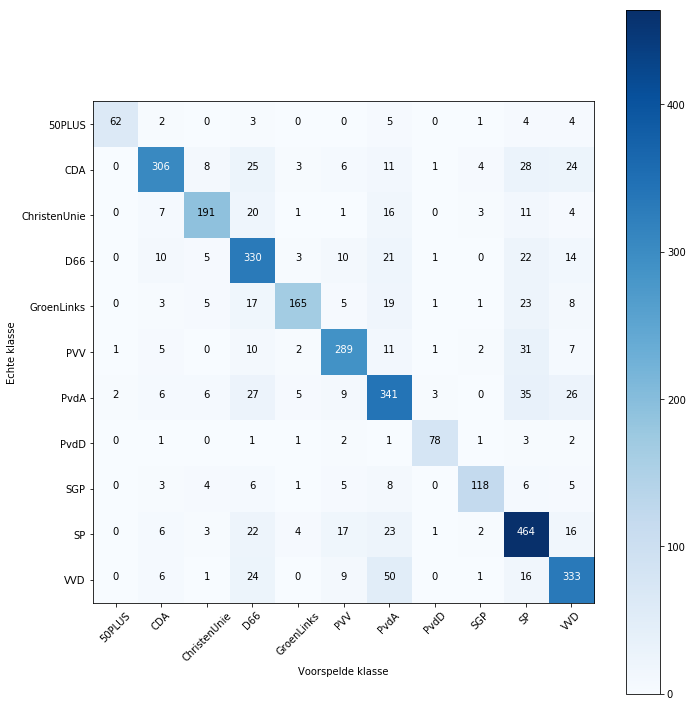

In [18]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix.png")
plt.show()

# Without Names

In [19]:
partijnamen = list(df.party.unique()) + ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie"]
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries")
df['withoutnames'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
df.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text,normal_text,withoutnames
286900,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
286901,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...,voorzitter vorig wek plaatst werkgever werknem...
286902,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...,voorzitter twee maand geled kreg dit kabinet v...
286903,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...,voorzitter allen al in de eerst drie maand van...
286912,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...,voorzitter we zijn eruit eerst ontdekt de mini...


In [20]:
kamerlidnamen

re.compile(r"Wilders|Roemer|Pechtold|Van Haersma Buma|Thieme|Slob|Samsom|Van Ojik|Van der Staaij|Zijlstra|Krol|Van Bommel|Klaver|Schouten|Verheijen|Bisschop|Madlener|Servaes|Segers|Ulenbelt|Van Toorenburg|Berndsen-Jansen|Bosma|Litjens|Tanamal|Karabulut|Voortman|Kuzu|Voordewind|Fritsma|Gesthuizen|Van Hijum|Schouw|Kooiman|Helder|Van der Steur|Van Tongeren|Klein|Marcouch|Verhoeven|Monasch|Paulus Jansen|Koolmees|Visser|Van Weyenberg|Agnes Mulder|Leijten|De Rouwe|Tony van Dijck|Van Veldhoven|Bashir|Elias|Dik-Faber|De Graaf|Kuiken|Pia Dijkstra|Bruins Slot|Van Veen|Klever|Sjoerdsma|Bergkamp|Jasper van Dijk|Venrooy-van Ark|Keijzer|Nijboer|Merkies|Aukje de Vries|Harbers|Dijkgraaf|Groot|Dikkers|Van Gerven|De Liefde|Geurts|Ouwehand|Graus|Houwers|Van Meenen|Lucas|Rog|Mohandis|Wolbert|Anne Mulder|Straus|Jadnanansing|Beertema|Smaling|Ypma|Lodders|Jan Vos|Van Raak|Taverne|Heijnen|Agema|Van Vliet|Omtzigt|Mei Li Vos|Van Klaveren|Yücel|Azmani|Bosman|Jacobi|Hachchi|Knops|Albert de Vries|Van der Linde|Lee

In [21]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
pipe.fit(list(df_train.withoutnames), list(df_train.party))
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


              precision    recall  f1-score   support

      50PLUS       0.82      0.52      0.64        86
         CDA       0.51      0.47      0.49       452
ChristenUnie       0.62      0.51      0.56       239
         D66       0.52      0.46      0.49       436
  GroenLinks       0.65      0.41      0.51       241
         PVV       0.58      0.77      0.66       369
        PvdA       0.52      0.47      0.49       436
        PvdD       0.56      0.69      0.62        81
         SGP       0.68      0.72      0.70       165
          SP       0.51      0.65      0.57       536
         VVD       0.54      0.53      0.54       436

 avg / total       0.56      0.55      0.55      3477



In [22]:
mostimportantwords(pipe, countdf, 'MostImportantWordsWithoutNames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,gepensioneerd,inwoner,gezinn,mijn fractie,schon,islamitisch,jonger,dier,punt,huurder,veilig
1,ouder,yyyyy fractie,ik heb,mijn,schon energie,brussel,kinder,bio industrie,eenverdiener,geheim dienst,yyyyy
2,50 plusser,reger,geestelijk,natur,bewindsperson,nederland,ieder kind,bio,allerlei,armoed,yyyyy fractie
3,plusser,yyyyy,voedselverspill,buitengewon,kamer hierover te,miljard,lager over,industrie,toen,segregatie,regelgev
4,50,de reger,prostitutie,vandag,voorzitter motie de,islam,voorzitter yyyyy,de bio industrie,beantwoord,mens,instrument
5,koopkrachtontwikkel,onz inwoner,rookvrij,hervorm,voorzitter motie,de islam,gezamen,de bio,vor de beantwoord,bestuurder,bedrijfslev
6,ouderenwerklos,eran,onder mer,het kabinet,in elk geval,belastingbetaler,verdien,constater dat,bewindslied,zegt,huis
7,gericht,antwoord,amendement,daarom,zou,asielzoeker,hulpverlener,dierenwelzijn,nadruk,herindel,wellicht
8,werkend,uiteind,motie,kabinet,elk geval,grenz,in die,burger,terrein,voorstell,aangegev
9,yyyyy,fractie,zull,fractie,persoonsgebond,verzorgingshuiz,tevred,verbod,mevrouw de voorzitter,bezuin,ban


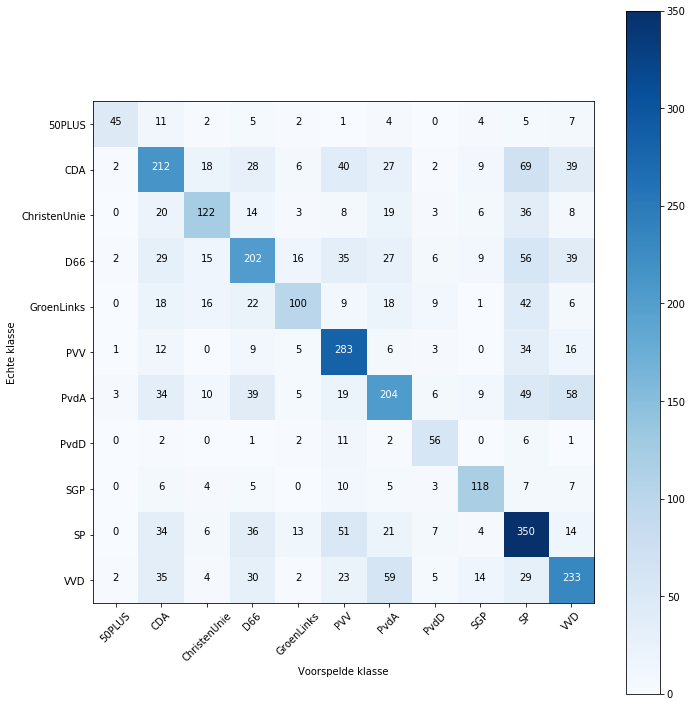

In [23]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix2.png")
plt.show()

# Git

In [24]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.csv
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames1.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames2.tex
!git add Verslag/Tables/MostImportantWords1.tex
!git add Verslag/Tables/MostImportantWords2.tex
!git add Models.xlsx
!git add Verslag/confusionmatrix.png
!git commit -m Update
!git push

Already up to date.


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedWriter name=6>
  return process_handler(cmd, _system_body)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedReader name=8>
  return process_handler(cmd, _system_body)
The file will have its original line endings in your working directory.


[master b5f9eae] Update
 6 files changed, 1037 insertions(+), 1518 deletions(-)
 rewrite CompleteNotebook.ipynb (83%)
 rewrite Verslag/Tables/MostImportantWords1.tex (94%)
 rewrite Verslag/Tables/MostImportantWords2.tex (95%)
 rewrite Verslag/Tables/MostImportantWordsWithoutNames1.tex (88%)
 rewrite Verslag/Tables/MostImportantWordsWithoutNames2.tex (95%)
 rewrite Verslag/confusionmatrix.png (99%)


To https://github.com/jaspervdh96/Scriptie-Sprekers-TK.git
   0f21516..b5f9eae  master -> master
